In [1]:
import sys; sys.path.append('../rrr')
from multilayer_perceptron import *
from local_linear_explanation import *
from figure_grid import *
from sklearn.datasets import fetch_20newsgroups
import sklearn
import lime
import lime.lime_text
from IPython.core.display import display
from IPython.core.display import HTML
from word_table import *

# 20 Newsgroups (alt.atheism vs. soc.religion.christian)

Let's try out input gradients on a text dataset, where they can be most easily compared to LIME (whose perturbations work really well for text). This example is also one of the ones showcased in the LIME documentation.

Still following LIME, we'll use a [TF-IDF vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with no stemming / lowercasing / stopword removal, because we're interested in seeing whether those words appear (and certain distinctions, like `god` vs `God`, are important for the atheism vs. Christianity subset). Since this notebook will be running on a laptop and our perceptron is relatively slow, we'll just use 5000 of the top features.

In [2]:
categories = ['alt.atheism', 'soc.religion.christian']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False, max_features=5000)
X = vectorizer.fit_transform(train.data).toarray()
Xt = vectorizer.transform(test.data).toarray()
y = train.target
yt = test.target

In [3]:
mlp = MultilayerPerceptron()
mlp.fit(X, y)
mlp.score(Xt, yt)

0.94700139470013944

Great, so we have a reasonably accurate classifier.

## Comparison with LIME

Let's generate both LIME and gradient-based explanations, then compare them:

In [5]:
import time

lime_explainer = lime.lime_text.LimeTextExplainer(class_names=test.target_names)

def lime_explain(mlp, texts):
  predict_proba = lambda text: np.exp(mlp.predict_proba(vectorizer.transform(text).toarray()))
  return [lime_explainer.explain_instance(txt, predict_proba, top_labels=1)
          for txt in texts]

n=100
t1 = time.clock()
lime_explanations = lime_explain(mlp, test.data[:n])
t2 = time.clock()
input_gradients = mlp.input_gradients(Xt[:n])
t3 = time.clock()
print('LIME took {:.5f}s/example'.format((t2-t1)/n))
print('grads took {:.5f}s/example, which is {:.0f}x faster'.format((t3-t2)/n, (t2-t1)/float(t3-t2)))

/Users/asross/.pyenv/versions/3.5.1/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


LIME took 2.98717s/example
grads took 0.00013s/example, which is 23274x faster


In [6]:
def lime_row(lime_expl):
  predkls = lime_expl.class_names[lime_expl.top_labels[0]]
  explist = lime_expl.as_list(label=lime_expl.top_labels[0])
  pos, neg, poswt, negwt = [], [], [], []
  for word, weight in explist:
    if weight > 0:
      pos.append(word)
      poswt.append(weight)
    else:
      neg.append(word)
      negwt.append(weight)
  return predkls, list(zip(poswt, pos)), list(zip(negwt, neg))

def grad_row(expl, cutoff=0.67, in_example=False):
  grad = expl.coefs
  x = expl.x
  y = expl.y
  if in_example:
    grad *= (x > 0)
  most_pos = grad > cutoff*np.abs(grad).max()
  most_neg = grad < -cutoff*np.abs(grad).max()
  pos_wwts = sorted(zip(grad[most_pos], vectorizer.inverse_transform(most_pos)[0]), reverse=True)
  neg_wwts = sorted(zip(grad[most_neg], vectorizer.inverse_transform(most_neg)[0]))
  return test.target_names[y], pos_wwts, neg_wwts

In [7]:
expls = mlp.grad_explain(Xt[:n])
lime_rows = [lime_row(l) for l in lime_explanations]
all_grad_rows_67 = [grad_row(g, cutoff=0.67) for g in expls]
inx_grad_rows_50 = [grad_row(g, in_example=True, cutoff=0.5) for g in expls]
inx_grad_rows_all = [grad_row(g,in_example=True,cutoff=0.0) for g in expls]

In [290]:
i = 32
display(HTML(compare_emails(test.data[i], inx_grad_rows_all[i], lime_rows[i], power=1)+'<style>hr{margin-top:10px}</style>'))
i = 15
display(HTML(compare_emails(test.data[i], inx_grad_rows_all[i], lime_rows[i])))

Here we see that input gradients and LIME tend to highlight exactly the same words with the same weight signs, but gradients highlight more of them (LIME generates sparse explanations). Let's look at a longer example:

In [284]:
i = 22
html = compare_emails(test.data[i], inx_grad_rows_all[i], lime_rows[i], power=1)
i = 60
html += compare_emails(test.data[i], inx_grad_rows_all[i], lime_rows[i], power=1)
with open('./foo2.html', 'w') as f:
  f.write(html.replace('</h4>', '</h4>\n').replace('</div>', '\n</div>\n\n').replace('<br><br>', '\n<br><br>\n\n'))

In [289]:
i = 22
display(HTML(compare_emails(test.data[i], inx_grad_rows_all[i], lime_rows[i], power=1)))
i = 60
display(HTML(compare_emails(test.data[i], inx_grad_rows_all[i], lime_rows[i], power=1)))

For longer documents, we should probably ask LIME to identify more features or sample from the document more times, because even though the words it identifies are significant, we don't necessarily get a full picture of the model's internal logic, which is really what we're looking for. Also, if a word we think _should_ be present in the explanation is missing in LIME, on long documents we can't be sure if LIME considered it irrelevant or if LIME failed to sample any versions of the document with that word masked out.

Another difference is that input gradients actually capture information about both words in the document and words outside it (that if added, would increase or decrease the probability of the predicted class). Let's take a look (with cutoffs now):

In [288]:
HTML(
  word_table(
    [lime_rows, inx_grad_rows_50, all_grad_rows_67],
    ['LIME', 'Gradients (in-example, M<sub>0.5</sub>)', 'Gradients (all components, M<sub>0.67</sub>)'],
    cutoff=10, maxwlen=30))

LIME,"Gradients (in-example, M0.5)","Gradients (all components, M0.67)"
auSorryguyrequestdeletedwroteEngamozname,SorrydeletedguyarticleauwroterequesteduEngammeUniversity,1993Apr15wouldnportalHostAmericansNewsreaderNNTPattemptdbstu1wishesinterestedPhilThankscgsvaxukysuspectgenevaarroganceadvanceChristians
altusualpolicyfreemoralitychargeinterestedangerdiscussionidentify,altpolicyusualfreeacceptableatheistreligiousentiredoninterestedclhMaymayangerlotanyonePaulHomosexualityrealized,1993Apr15wouldnportalHostAmericansNewsreaderNNTPattemptdbstu1wishesinterestedPhilThankscgsvaxukysuspectgenevaarroganceadvanceChristians
madhausHausmannnicknameThingstimmbakemclSchneiderKeithnetcom408,SchneiderKeithCaliforniaatheistsmadhausnicknameeduwritesMaddiBake408,wouldnHostaveragewishesAmericansdbstu1psuportalpoohwestChristiansinterestedarrogancePhilsuspectadvanceThanksgenevacgsvaxByler
ChristiansPaulGodnorusritualwebehavioryoufree,ChristiansrutgersChristianathoscamemineMaymaySpiritimmediatelywishesgodagreepickusingignoreWellfreedrivenmen,interestedPhilThanksChristiansukysuspectcgsvaxgenevaarroganceadvancewouldnportal1993Apr15AmericansNewsreaderattemptdbstu1Hostwishescourt
drawnwithinsciencetheoriesquestionsBruceSciencesScienceUnivask,HostNNTPPostingstatedalexiaEarthEDUCobbarticlecobbSciencesUnivespeciallyunderstandingChristianityasktruthGodmerecalled,1993Apr15wouldnportalHostAmericansNewsreaderNNTPattemptdbstu1wishesinterestedPhilThankscgsvaxukysuspectgenevaarroganceadvanceChristians
ScripturesHudsonrelationshipsweemotionalissexagreeadultacts,ChristiansgenevarutgersMaymayathenaimmediatelyChristianityHudsontempleagreehumanswithinadultraiseSo,interestedPhilThankssuspectChristiansarroganceadvancecgsvaxukyperishwouldnattempt1993Apr15portalexecutionwishesAmericansRosenauresponsiblecourt
ChristrevdaksheGodServicesBylerAndrewherHeavenconsistency,BylerQuestionServicesChurchHisdb7nChristKilleGodgoddesspsychologicalsaidgettingwomenconsistencymentionedandrewrequiresmetaphysicalcmu,interestedPhilThankscgsvaxukysuspectgenevaarroganceadvanceChristians1993Apr15wouldnportalHostAmericansNewsreaderNNTPattemptdbstu1wishes
hellfireHellGodJesusthreatlloLarrystruggleagree,ChristiansclhextremeHellworkingfirepsilothellChristagreeNewsexampleremovedWereusualisnstruggledonconsequences,interestedPhilThanksukyarrogancesuspectChristiansadvancecgsvaxgenevaNNTPHost1993Apr15Newsreaderwouldndbstu1Americansportalwishesattempt
ChristianityChristianChristchurchChristiansattemptusingdefinitiondefinitionssgi,ChristiansChristianclhdiscussionsfeltjudgementprevioussubjectchurchHisattemptagreesgiusinglevelgodsrespondlimitargueYet,interestedPhilThanksChristiansukysuspectcgsvaxgenevaarroganceadvancewouldnportal1993Apr15AmericansNewsreaderattemptdbstu1Hostwishescourt
mcculloutimmbakemclprotectionwiscatheistsprojectscaredtheSciences,dedrinkusingmccullouBakeSorryatheistsMcCulloughversionClintonSciencesemailmayDeptprojectworkscaredhowthrough,1993Apr15wouldnportalHostAmericansNewsreaderNNTPattemptdbstu1wishesinterestedPhilThankscgsvaxukysuspectgenevaarroganceadvanceChristians


As in the previous section, we see a fair amount of overlap between LIME and the in-example input gradients, though the top-weighted words aren't exactly the same.  "In-example" just means we've limited the input gradients to words that appear in the document; i.e., they tell us that the presence of words in the input were positive or negative predictors of the predicted class. Words that show up in the "all components" gradients are words that may not exist in the document at all, but would increase or decrease the probability of the predicted class if added.

The fact that this method produces very similar results to LIME despite the different perturbation methods -- LIME selectively masks words then fits a linear model, while input gradients measure the effect of infinitesimal changes -- is pretty cool. And as we see above, it's much faster (and could be even faster with a more performant implementation).

## Find-another-explanation

Let's see what happens when we apply this technique. 20 Newsgroups is a very "messy" dataset, and there are many differences in the distributions of words between classes, so we shouldn't expect accuracy to fall off a cliff.

In [11]:
fae_iters = 8
fae_models = []
A = np.zeros_like(X).astype(bool)
for i in range(fae_iters):
  mlp = MultilayerPerceptron(l2_grads=250)
  mlp.fit(X, y, A)
  fae_models.append(mlp)
  A += mlp.largest_gradient_mask(X)

In [12]:
trn_scores = [mlp.score(X,y) for mlp in fae_models]
tst_scores = [mlp.score(Xt,yt) for mlp in fae_models]
fae_rows = [[grad_row(g) for g in mlp.grad_explain(Xt[:5])] for mlp in fae_models]

M0.67[fX|θ0],M0.67[fX|θ1],M0.67[fX|θ2],M0.67[fX|θ3],M0.67[fX|θ4],M0.67[fX|θ5],M0.67[fX|θ6]
missiongenevachristianarrogancesinChuckBillAnSeemsRyanICOartificial,MarHeavenEphesiansheavendenominationsSourcedarksideeyemottorulinghrsperry,jodfishefisherLostprovidenceMicrosystemsheartNY,CreatorpresentingJrvacuumGeorgiaChristopherKnowleslackingFreedomeagle127Charley,uthskynativeinfectiousRevBlessedUnitedStatesdependsmiscpregnantatheist,ScientistpopularavoidremainedNewPauldirectlyamazingsurvivalrewardconcerned,fundamentalBeingtakenstudentsFisherMohammadIslamjondepressionunicornsbookrisk


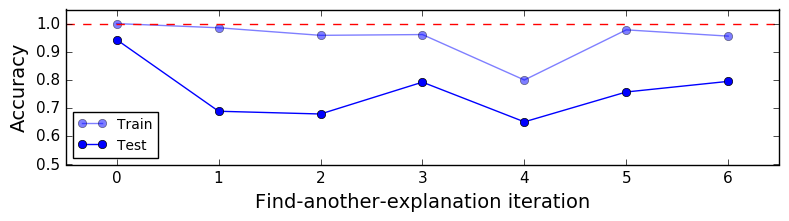

In [287]:
cutoff = 7
headers = ['M<sub>0.67</sub>[f<sub>X</sub>|θ<sub>{}</sub>]'.format(i) for i in range(cutoff)]

display(HTML(
  word_table(
    fae_rows[:cutoff],
    headers,
    style='table-layout:fixed; margin-left:4.62em;', startafter=3, cutoff=3, scale=0.25, maxwlen=5, maxwords=6)))

plt.figure(figsize=(9.205,2))
plt.plot(list(range(cutoff)), trn_scores[:cutoff], marker='o', label='Train', alpha=0.5, c='blue')
plt.plot(list(range(cutoff)), tst_scores[:cutoff], marker='o', label='Test', c='blue')
plt.axhline(1, ls='--', c='red')
plt.xlim(-0.5, cutoff-0.5)
plt.ylim(0.5, 1.05)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Find-another-explanation iteration', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=11)

plt.show()

So, this is kind of interesting. Train accuracy remains pretty high initially but slowly tails off, whereas test accuracy wobbles around. These results aren't completely consistent across retrains; sometimes test accuracy remains high for more interations.

Looking at the actual explanations though, you can see that after each iteration, the words considered most predictive change pretty significantly, but in each case they still make intuitive sense. Also, the fact that test accuracy sometimes increases later into the find-another-explanation iterations suggests that there are important features we miss in the first iteration. One idea could be to run find-another-explanation on a subset of the training set, test against the rest (as a validation set), then use that to generate a set of annotations $A$ we think might generalize better -- though maybe the problem is more fundamental, and had we included the validation set in the initial training process, we would have gotten a similar model anyway.